In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
# TQQQ Portfolio
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import os
import re
from tqdm.auto import tqdm
from datetime import datetime

plt.style.use('seaborn-v0_8-darkgrid')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

MODEL_PATH = 'unique_itransformer.pth'
LOOKBACK = 20
HORIZONS = [1, 5, 10]


Device: cpu


In [30]:
# ============================================================================
# 데이터 로더
# ============================================================================

def clean_currency(x):
    if isinstance(x, str):
        return float(re.sub(r'[$,]', '', x))
    return x


def load_stock_data(file_paths):
    name_map = {
        'PALANTIR': 'PLTR', 'NVIDIA': 'NVDA', 'BROADCOM': 'AVGO',
        'ALPHABET': 'GOOGL', 'AMAZON': 'AMZN', 'NETFLIX': 'NFLX',
        'TESLA': 'TSLA', 'META': 'META', 'MICROSOFT': 'MSFT', 'APPLE': 'AAPL'
    }

    data_dict = {}
    print("\n" + "="*60)
    print("Loading Stock Data...")
    print("="*60)

    for path in file_paths:
        filename = os.path.basename(path).upper()
        ticker = next((val for key, val in name_map.items() if key in filename), None)

        if ticker:
            try:
                df = pd.read_csv(path)
                df['Date'] = pd.to_datetime(df['Date'])

                if 'Close/Last' in df.columns:
                    df['Close'] = df['Close/Last'].apply(clean_currency)
                elif 'Close' in df.columns:
                    df['Close'] = df['Close'].apply(clean_currency)

                df = df[['Date', 'Close']].set_index('Date').sort_index()
                data_dict[ticker] = df['Close']
                print(f"  ✓ {ticker:6s}: {len(df):,} rows")

            except Exception as e:
                print(f"  ✗ Error: {e}")

    combined_df = pd.DataFrame(data_dict).dropna()
    latest_date = combined_df.index[-1]
    print(f"\n✓ Total: {len(combined_df):,} days, {len(combined_df.columns)} stocks")
    print(f"✓ Latest data: {latest_date.date()}\n")

    return combined_df


def create_multi_horizon_dataset(returns_df, lookback=LOOKBACK, horizons=HORIZONS):
    X = []
    y_dict = {h: [] for h in horizons}

    data_values = returns_df.values
    max_horizon = max(horizons)

    if len(data_values) <= lookback + max_horizon:
        return np.array([]), {}

    for i in range(len(data_values) - lookback - max_horizon):
        raw_window = data_values[i : i + lookback]
        w_mean = np.mean(raw_window, axis=0)
        w_std = np.std(raw_window, axis=0) + 1e-6
        norm_window = (raw_window - w_mean) / w_std

        X.append(norm_window)

        for h in horizons:
            raw_target = data_values[i + lookback + h - 1]
            norm_target = (raw_target - w_mean) / w_std
            y_dict[h].append(norm_target)

    X = np.array(X)
    y_dict = {h: np.array(y_list) for h, y_list in y_dict.items()}

    return X, y_dict


In [31]:
# ============================================================================
# Model
# ============================================================================

class MultiHorizonITransformer(nn.Module):
    def __init__(self, num_stocks, lookback=LOOKBACK, horizons=HORIZONS, d_model=128, n_heads=4):
        super().__init__()
        self.horizons = horizons

        self.embedding = nn.Linear(lookback, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            batch_first=True,
            dropout=0.1,
            dim_feedforward=d_model * 2
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=3)

        self.predictors = nn.ModuleDict({
            str(h): nn.Linear(d_model, 1) for h in horizons
        })

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.embedding(x)
        encoded = self.encoder(x)

        predictions = {}
        for h in self.horizons:
            pred = self.predictors[str(h)](encoded).squeeze(-1)
            predictions[h] = pred

        # Auto-confidence
        pred_stack = torch.stack([predictions[h] for h in self.horizons], dim=-1)
        pred_std = torch.std(pred_stack, dim=-1) + 1e-6
        confidences = 1.0 / (1.0 + pred_std)
        confidences = 0.3 + 0.6 * confidences

        return predictions, confidences


class ConfidenceWeightedLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss(reduction='none')
        self.horizon_weights = {1: 1.0, 5: 0.7, 10: 0.5}

    def forward(self, predictions, targets, confidences):
        total_loss = 0.0
        for h, pred in predictions.items():
            target = targets[h]
            mse = self.mse(pred, target)
            weighted_mse = mse * confidences
            loss = weighted_mse.mean() * self.horizon_weights[h]
            total_loss += loss
        return total_loss


def train_model(data_df, epochs=100):
    print("="*60)
    print("Training Multi-Horizon iTransformer")
    print("="*60)

    returns_df = np.log(data_df / data_df.shift(1)).dropna()

    train_returns = returns_df.iloc[:-120]
    val_returns = returns_df.iloc[-120:]

    X_train, y_train = create_multi_horizon_dataset(train_returns)
    X_val, y_val = create_multi_horizon_dataset(val_returns)

    print(f"Train samples: {len(X_train)}")
    print(f"Val samples: {len(X_val)}")
    print(f"Horizons: {HORIZONS}\n")

    train_dataset = torch.utils.data.TensorDataset(
        torch.FloatTensor(X_train),
        *[torch.FloatTensor(y_train[h]) for h in HORIZONS]
    )
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=32, shuffle=True
    )

    X_val_tensor = torch.FloatTensor(X_val).to(device)
    y_val_tensors = {h: torch.FloatTensor(y_val[h]).to(device) for h in HORIZONS}

    num_stocks = data_df.shape[1]
    model = MultiHorizonITransformer(num_stocks, LOOKBACK, HORIZONS).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)
    criterion = ConfidenceWeightedLoss()

    best_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for batch_data in train_loader:
            bx = batch_data[0].to(device)
            by = {h: batch_data[i+1].to(device) for i, h in enumerate(HORIZONS)}

            optimizer.zero_grad()
            preds, confs = model(bx)
            loss = criterion(preds, by, confs)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        model.eval()
        with torch.no_grad():
            val_preds, val_confs = model(X_val_tensor)
            val_loss = criterion(val_preds, y_val_tensors, val_confs).item()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), MODEL_PATH)

        if (epoch + 1) % 10 == 0:
            avg_conf = val_confs.mean().item()
            min_conf = val_confs.min().item()
            max_conf = val_confs.max().item()
            print(f"Epoch {epoch+1:3d}/{epochs} | "
                  f"Train: {train_loss:.5f} | "
                  f"Val: {val_loss:.5f} | "
                  f"Conf: {avg_conf:.3f} ({min_conf:.3f}~{max_conf:.3f})")

    print(f"\n✓ Best Val Loss: {best_val_loss:.5f}\n")
    return model


def calculate_hybrid_weights(predictions, confidences, momentum, volatility):
    combined_pred = (
        0.5 * predictions[1] +
        0.3 * predictions[5] +
        0.2 * predictions[10]
    )

    confidence_adjusted = combined_pred * confidences
    momentum_score = np.clip(momentum / (volatility + 1e-6), -2, 2)
    hybrid_score = 0.7 * confidence_adjusted + 0.3 * momentum_score

    z_scores = (hybrid_score - hybrid_score.mean()) / (hybrid_score.std() + 1e-6)

    temperature = 0.6
    exp_scores = np.exp(z_scores / temperature)
    weights = exp_scores / np.sum(exp_scores)

    weights = np.round(weights, 4)
    weights = weights / np.sum(weights)

    return weights

In [32]:
# ============================================================================
# 포트폴리오 비중 출력
# ============================================================================

def generate_portfolio_weights(data_df):
    """
    포트폴리오 비중 출력

    Returns:
        weights_df: (종목, 2) DataFrame
                    컬럼: ['Weight', 'Weight (%)']
    """

    print("="*60)
    print("Generating Portfolio Weights (Latest)")
    print("="*60)

    returns_df = np.log(data_df / data_df.shift(1)).dropna()
    tickers = returns_df.columns.tolist()
    num_stocks = len(tickers)

    if not os.path.exists(MODEL_PATH):
        print("Model not found!")
        return None

    model = MultiHorizonITransformer(num_stocks, LOOKBACK, HORIZONS).to(device)
    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    model.eval()

    # 🔥 최신 날짜 데이터 사용
    latest_date = returns_df.index[-1]
    print(f"📅 Prediction Date: {latest_date.date()}")
    print(f"🗓️  Today: {datetime.now().date()}\n")

    # 최근 20일 데이터로 예측
    raw_window = returns_df.iloc[-LOOKBACK:].values
    w_mean = np.mean(raw_window, axis=0)
    w_std = np.std(raw_window, axis=0) + 1e-6
    norm_window = (raw_window - w_mean) / w_std

    input_tensor = torch.FloatTensor(norm_window).unsqueeze(0).to(device)

    with torch.no_grad():
        preds, confs = model(input_tensor)
        predictions = {h: preds[h].cpu().numpy().flatten() for h in HORIZONS}
        confidences = confs.cpu().numpy().flatten()

    # Momentum & Volatility
    momentum = returns_df.iloc[-LOOKBACK:].sum(axis=0).values
    volatility = returns_df.iloc[-LOOKBACK:].std(axis=0).values

    # 비중 계산
    weights = calculate_hybrid_weights(
        predictions, confidences, momentum, volatility
    )

    # DataFrame 생성
    weights_dict = {ticker: weight for ticker, weight in zip(tickers, weights)}

    weights_df = pd.DataFrame.from_dict(
        weights_dict,
        orient='index',
        columns=['Weight']
    )
    weights_df['Weight (%)'] = weights_df['Weight'].apply(lambda x: f"{x*100:.2f}%")
    weights_df['Confidence'] = confidences
    weights_df['Confidence (%)'] = weights_df['Confidence'].apply(lambda x: f"{x*100:.1f}%")

    # 비중 높은 순으로 정렬
    weights_df = weights_df.sort_values('Weight', ascending=False)

    print("="*80)
    print("최적의 포트폴리오 비율 (Multi-Horizon iTransformer + Confidence):")
    print("="*80)
    print(weights_df)

    print("\n" + "="*80)
    print("포트폴리오 통계:")
    print("="*80)
    print(f"평균 신뢰도: {confidences.mean():.3f} ({confidences.min():.3f} ~ {confidences.max():.3f})")
    print(f"최대 비중 종목: {weights_df.index[0]} ({weights_df['Weight (%)'].iloc[0]})")
    print(f"Top 3 비중 합계: {weights_df['Weight'].head(3).sum()*100:.1f}%")
    print(f"분산도: {'높음' if weights_df['Weight'].std() < 0.15 else '보통' if weights_df['Weight'].std() < 0.25 else '낮음'}")

    return weights_df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
UNIQUE iTransformer Portfolio System
Reference Code Format Output
Run Date: 2025-12-29

Loading Stock Data...
  ✓ PLTR  : 1,256 rows
  ✓ NVDA  : 1,256 rows
  ✓ AVGO  : 1,256 rows
  ✓ GOOGL : 1,256 rows
  ✓ AMZN  : 1,256 rows
  ✓ NFLX  : 1,256 rows
  ✓ TSLA  : 1,256 rows
  ✓ META  : 1,256 rows
  ✓ MSFT  : 1,256 rows
  ✓ AAPL  : 1,256 rows

✓ Total: 1,256 days, 10 stocks
✓ Latest data: 2025-10-31

Training Multi-Horizon iTransformer
Train samples: 1165
Val samples: 90
Horizons: [1, 5, 10]

Epoch  10/100 | Train: 2.43920 | Val: 2.51294 | Conf: 0.681 (0.565~0.892)
Epoch  20/100 | Train: 2.24442 | Val: 2.49953 | Conf: 0.712 (0.540~0.892)
Epoch  30/100 | Train: 1.95571 | Val: 2.55239 | Conf: 0.702 (0.544~0.896)
Epoch  40/100 | Train: 1.68619 | Val: 2.55665 | Conf: 0.675 (0.516~0.879)
Epoch  50/100 | Train: 1.51236 | Val: 2.52291 | Conf: 0.670 (0.500~0.880)
Epoch  6

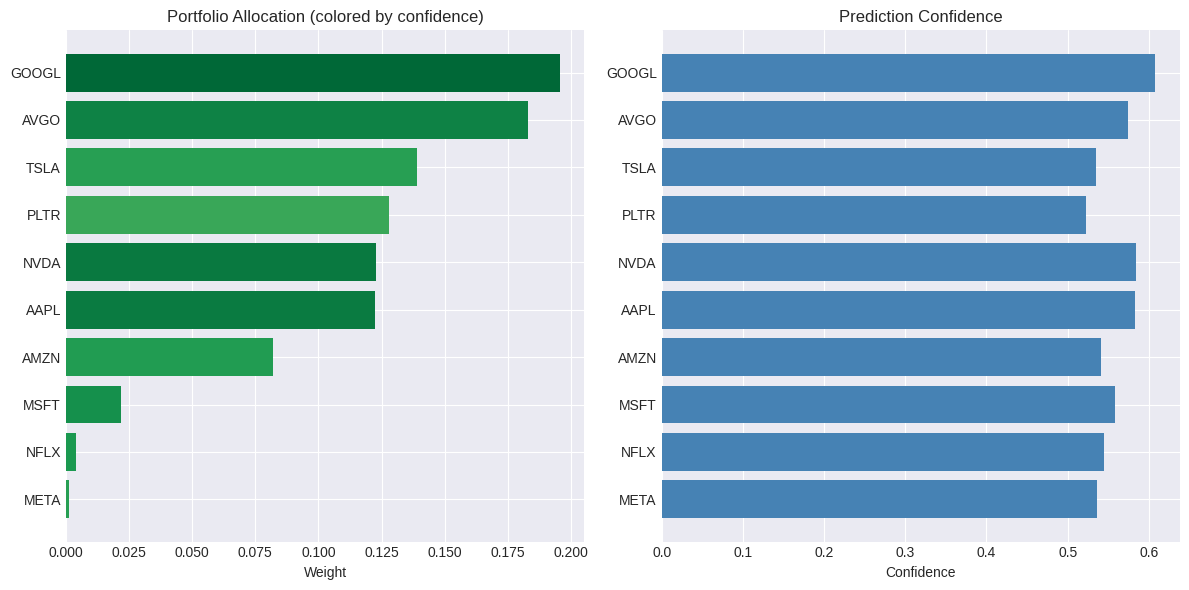

✓ Saved: portfolio_visualization.png

✅ Complete!

📊 Final Output
       Weight Weight (%)  Confidence Confidence (%)
GOOGL  0.1955     19.55%    0.607947          60.8%
AVGO   0.1829     18.29%    0.574036          57.4%
TSLA   0.1390     13.90%    0.535299          53.5%
PLTR   0.1278     12.78%    0.521977          52.2%
NVDA   0.1229     12.29%    0.584238          58.4%
AAPL   0.1225     12.25%    0.583162          58.3%
AMZN   0.0822      8.22%    0.541215          54.1%
MSFT   0.0219      2.19%    0.557945          55.8%
NFLX   0.0040      0.40%    0.545147          54.5%
META   0.0013      0.13%    0.535605          53.6%


In [33]:
# ============================================================================
# Main
# ============================================================================

def main():
    print("="*60)
    print("UNIQUE iTransformer Portfolio System")
    print("Reference Code Format Output")
    print(f"Run Date: {datetime.now().date()}")
    print("="*60)

    file_paths = [
        '/content/drive/MyDrive/TQQQ/PALANTIR 5년치.csv',
        '/content/drive/MyDrive/TQQQ/NVIDIA 5년치.csv',
        '/content/drive/MyDrive/TQQQ/BROADCOM 5년치.csv',
        '/content/drive/MyDrive/TQQQ/ALPHABET C 5년치.csv',
        '/content/drive/MyDrive/TQQQ/AMAZON 5년치.csv',
        '/content/drive/MyDrive/TQQQ/NETFLIX 5년치.csv',
        '/content/drive/MyDrive/TQQQ/TESLA 5년치.csv',
        '/content/drive/MyDrive/TQQQ/META 5년치.csv',
        '/content/drive/MyDrive/TQQQ/MICROSOFT 5년치.csv',
        '/content/drive/MyDrive/TQQQ/APPLE 5년치.csv'
    ]

    # 1. Load
    data_df = load_stock_data(file_paths)

    # 2. Train
    model = train_model(data_df, epochs=100)

    # 3. Generate Portfolio
    weights_df = generate_portfolio_weights(data_df)

    if weights_df is not None:
        # CSV 저장
        weights_df.to_csv('portfolio_weights.csv')
        print("\n✓ Saved: portfolio_weights.csv")

        # 시각화
        plt.figure(figsize=(12, 6))

        # 왼쪽: 비중
        plt.subplot(1, 2, 1)
        colors = plt.cm.RdYlGn(weights_df['Confidence'] / weights_df['Confidence'].max())
        plt.barh(weights_df.index, weights_df['Weight'], color=colors)
        plt.xlabel('Weight')
        plt.title('Portfolio Allocation (colored by confidence)')
        plt.gca().invert_yaxis()

        # 오른쪽: 신뢰도
        plt.subplot(1, 2, 2)
        plt.barh(weights_df.index, weights_df['Confidence'], color='steelblue')
        plt.xlabel('Confidence')
        plt.title('Prediction Confidence')
        plt.gca().invert_yaxis()

        plt.tight_layout()
        plt.savefig('portfolio_visualization.png', dpi=150, bbox_inches='tight')
        plt.show()
        print("✓ Saved: portfolio_visualization.png")

    print("\n" + "="*60)
    print("✅ Complete!")
    print("="*60)

    return weights_df


if __name__ == "__main__":
    try:
        from google.colab import drive
        drive.mount('/content/drive')
    except:
        pass

    weights_df = main()

    print("\n" + "="*80)
    print("📊 Final Output")
    print("="*80)
    print(weights_df)